In [1]:
import dolphindb as ddb
import talib as ta
import re
s=ddb.session()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
s.connect('10.0.60.55',8509,'admin','123456')
z=ddb.session()
z.connect('10.0.40.33',8505,'admin','123456')

True

In [2]:
import dolphindb as ddb
import talib as ta
import re
s=ddb.session()
import pandas as pd
import numpy as np
s.connect('10.0.60.55',8509,'admin','123456')
z=ddb.session()
z.connect('10.0.40.33',8505,'admin','123456')

class ETFClassification:
    def __init__(self):
        # 511380 & 500060 is missing for Bond ETF
        self.etf_dict = {
            'BigCapIndex': ['510300', '510330', '510050', '159919', '510310'],
            'SmallCapIndex': ['159949', '510500', '159915', '512500', '159968'],
            'TotalMarketIndex': ['515800', '512990', '512380', '512160', '512090'],
            'TMTSector': ['159995', '512760', '515050', '159801', '512480'],
            'BioMedicalSector': ['512290', '159992', '512170', '512010', '159938'],
            'TechTopic': ['515000', '515750', '159807', '515860', '159987'],
            'NEVTopic': ['515030', '515700', '159806'],
            'RealEstateSector': ['512880', '512000', '512800', '512900', '159993'],
            'ConsumptionSector': ['159928', '512690', '515650', '159996', '510150'],
            'MilitarySector': ['512660', '512710'],
            'PeriodicSector': ['515210', '512400', '515220'],
            'SmartBeta': ['159966', '159905', '159967', '510880', '515180'],
            'Other': ['515680', '515900', '159976', '515600', '159978'],
            'Bond': ['511010', '511260', '159972'],
            'QDII': ['510900', '159920', '513050', '513090', '513500'],
            'Commodity': ['518880', '159934', '159937', '518800', '159980'] 
        }

    def etf_daily_avg_turnover(self, symbol):
        if symbol[:2] == '51': 
            db = "'dfs://STOCK_SH_TRDMIN','STOCK_SH_TRDMIN'"
        elif symbol[:2] == '15': 
            db = "'dfs://STOCK_SZ_TRDMIN','STOCK_SZ_TRDMIN'"
        else:
            raise AttributeError(f"{symbol} is not identified as a valid ETF symbol")
        
        sql = f"select sum(turnover) as turnover_daily \
                from loadTable({db})  \
                where symbol = `{symbol}, cycle = 1, tradingDay < 2018.02.01 \
                group by tradingDay"
        data = s.run(sql)

        sql2 = f"select last(turnover) as turnover_daily \
                from loadTable({db})  \
                where symbol = `{symbol}, cycle = 1, tradingDay >= 2018.02.01 \
                group by tradingDay"
        data2 = s.run(sql2)
        res = pd.concat([data, data2])
        if len(res) == 0:
            raise AttributeError(f"{symbol} is not identified as a valid ETF symbol")

        return res['turnover_daily'].mean()

    def etf_avg_spread(self, symbol):
        if symbol[:2] == '51': 
            sql = f"select symbol, date, time, askPrice1, bidPrice1  \
                    from loadTable('dfs://STOCK_SHL2_TAQ','SHL2_TAQ')  \
                    where symbol = `{symbol}"
        elif symbol[:2] == '15': 
            sql = f"select symbol, date, time, askPrice1, bidPrice1 \
                    from loadTable('dfs://STOCK_SZL2_TAQ','SZL2_TAQ')  \
                    where symbol = `{symbol}"
        else:
            raise AttributeError(f"{symbol} is not identified as a valid ETF symbol")
        data = s.run(sql)
        if len(data) == 0:
            raise AttributeError(f"{symbol} is not identified as a valid ETF symbol")
        len_ttl = len(data)
        data.drop(data[(data['askPrice1'] == 0) | (data['bidPrice1'] == 0) | (data['askPrice1'] < data['bidPrice1'])].index, 
                  inplace = True)
        data.reset_index(drop = True, inplace = True)
        len_clean = len(data)
        data['spread'] = data['askPrice1'] - data['bidPrice1']
        return data['spread'].mean(), data['spread'].quantile(0.1), data['spread'].quantile(0.9), (len_ttl - len_clean)/len_ttl
    
    def etf_vol(self, symbol, tag = 'close', window = 10 * 4 * 60):
        if symbol[:2] == '51': 
            sql = f"select symbol, tradingDay, time, {tag} \
                    from loadTable('dfs://STOCK_SH_TRDMIN','STOCK_SH_TRDMIN') \
                    where symbol = `{symbol}, cycle = 1 \
                    order by tradingDay, time"
        elif symbol[:2] == '15' or symbol[:2] == '39' or symbol[:2] == '00': 
            sql = f"select symbol, tradingDay, time, {tag} \
                    from loadTable('dfs://STOCK_SZ_TRDMIN','STOCK_SZ_TRDMIN') \
                    where symbol = `{symbol}, cycle = 1 \
                    order by tradingDay, time"
        else:
            raise AttributeError(f"{symbol} is not identified as a valid ETF symbol")
        data = s.run(sql)
        if len(data) == 0:
            raise AttributeError(f"{symbol} is not identified as a valid ETF symbol")

        # replace tag value of 0 with previous value (dealing with missing values)
        idx = np.where(data[tag] == 0)[0]
        for i in idx:
            data[tag].iloc[i] = data[tag].iloc[i-1]
        # calculate return
        data['return'] = np.log(data[tag]) - np.log(data[tag].shift(1))
        data.dropna(inplace = True)
        vol = data['return'].std() * np.sqrt(252 * 4 * 60)
        data['vol_window'] = data['return'].rolling(window = window).std() * np.sqrt(252 * 4 * 60)
        return vol, data[['symbol', 'tradingDay', 'time', 'return','vol_window']]
c = ETFClassification()

In [11]:
res = pd.DataFrame(columns = ['Symbol', 'Type', 'Daily Turover', 'Avg Spread', '10% Spread ', '90% Spread ', 'Clean Rate', 'Annual Vol'])
idx = 0
data_dict = {}
for k, v in c.etf_dict.items():
    for symbol in v:
        try:
            vol = c.etf_vol(symbol)
            turnover = c.etf_daily_avg_turnover(symbol)
            spread = c.etf_avg_spread(symbol) 
            res.loc[idx] = [
                symbol, 
                k, 
                turnover,
                spread[0],
                spread[1],
                spread[2],
                spread[3],
                vol[0]
            ]
            data_dict[symbol] = vol[1]
            idx += 1
        except AttributeError as e:
            print(e)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [29]:
pd.set_option('max_columns',1000)
pd.set_option('max_row', 300)
res

,Type,Daily Turover,Avg Spread,10% Spread,90% Spread,Clean Rate,Annual Vol
Symbol,,,,,,,
510300,BigCapIndex,1.284214e+09,0.001246,0.001,0.002,0.000786,0.222618
510330,BigCapIndex,1.713188e+08,0.004249,0.001,0.009,0.000458,0.298445
510050,BigCapIndex,1.089855e+09,0.001083,0.001,0.001,0.000383,0.258059
159919,BigCapIndex,2.708101e+08,0.002079,0.001,0.004,0.001917,0.424175
510310,BigCapIndex,3.193549e+07,0.002060,0.001,0.004,0.000938,0.345603
159949,SmallCapIndex,2.941898e+08,0.001107,0.001,0.001,0.000280,0.329510
510500,SmallCapIndex,4.510816e+08,0.002769,0.001,0.005,0.001143,0.572645
159915,SmallCapIndex,5.281489e+08,0.001180,0.001,0.002,0.002998,0.320084
512500,SmallCapIndex,6.939130e+07,0.005466,0.001,0.015,0.001533,0.442775


In [3]:
from datetime import datetime
# 对齐时间戳
def combine_time(df,tag1 = 'tradingDay', tag2 = 'time'):
    new_idx = []
    df[ 'datetime'] = df[[tag1, tag2]].apply(lambda x: datetime.combine(x[0].date(), x[1].time()), axis = 1)
    df.set_index('datetime',inplace = True)
    col_list = set(df.columns)
    col_list.remove(tag1)
    col_list.remove(tag2)
    col_list.remove('symbol')
    return df[col_list]

In [36]:
vol_dict = {}
return_dict = {}
for k, v in c.etf_dict.items():
    for symbol in v:
        res = combine_time(data_dict[symbol])
        vol_dict[symbol] = res[ 'vol_window'].dropna()
        return_dict[symbol] = res['return']
        

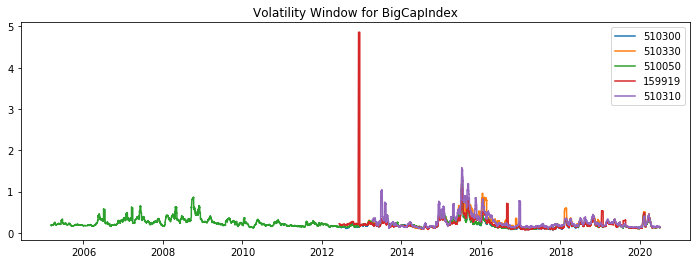

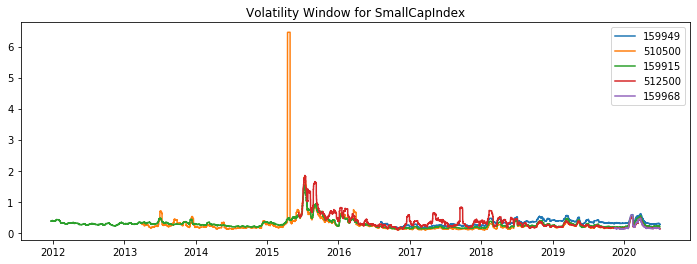

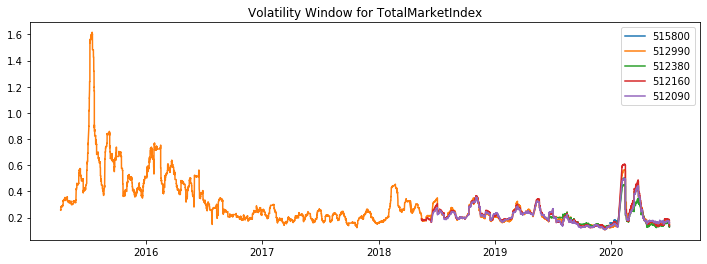

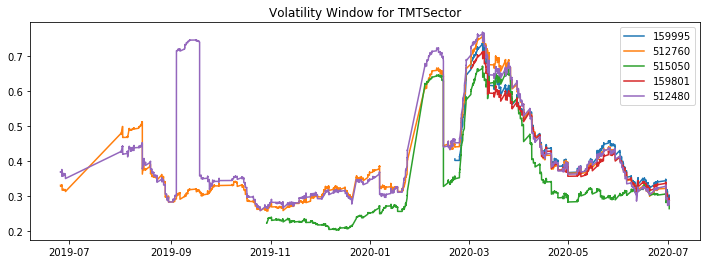

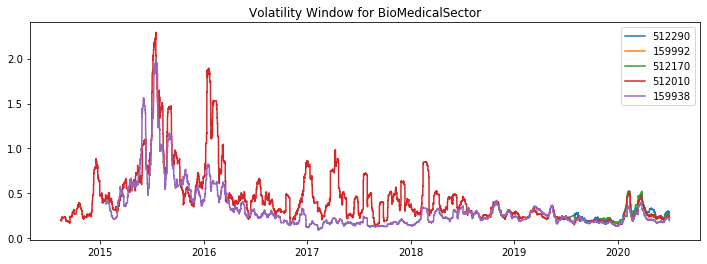

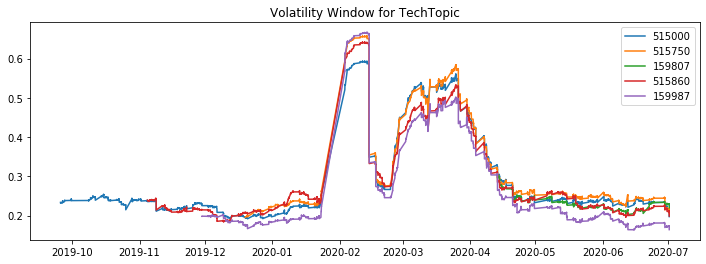

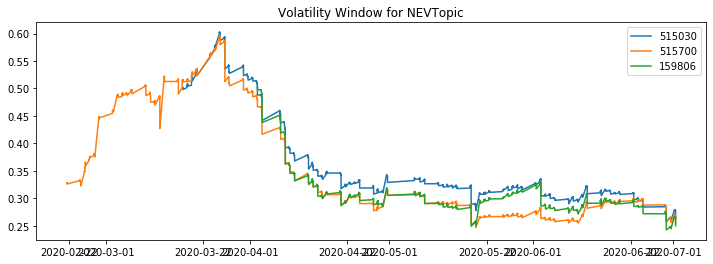

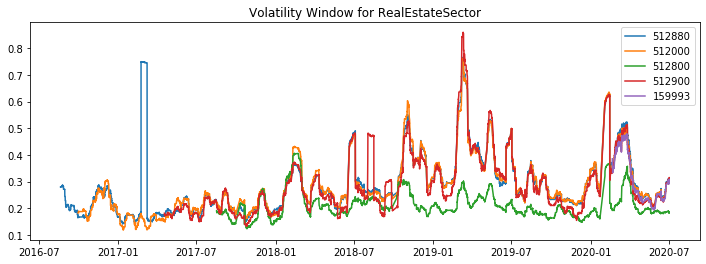

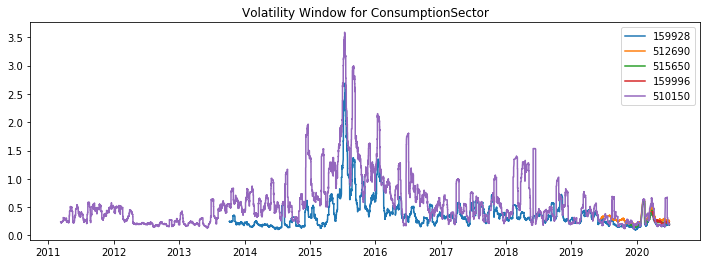

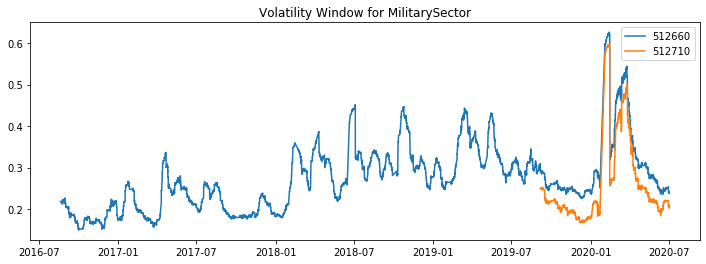

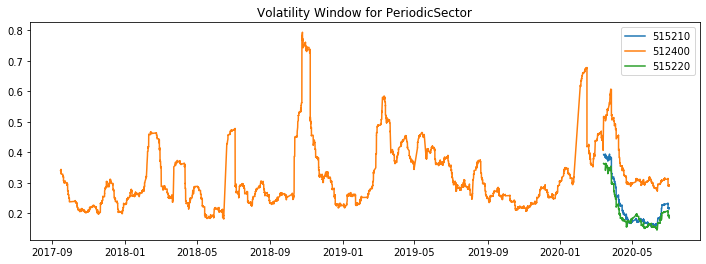

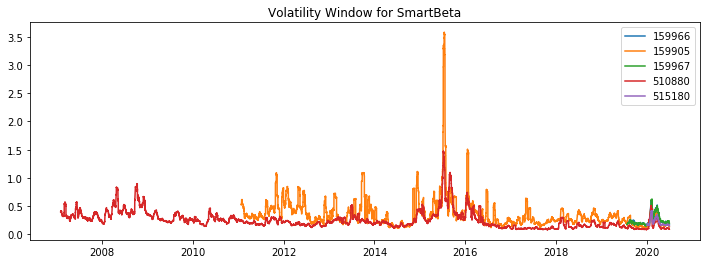

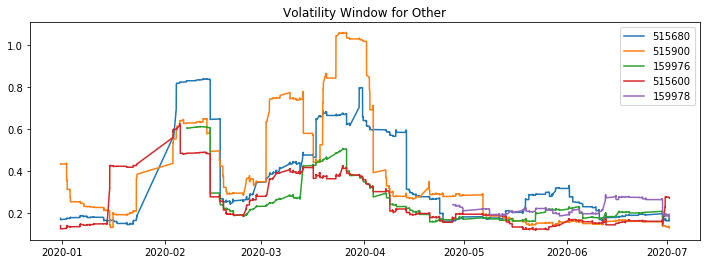

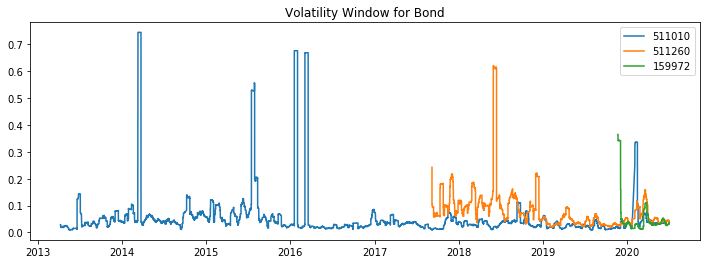

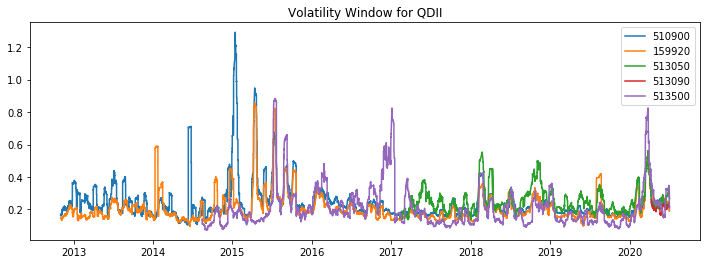

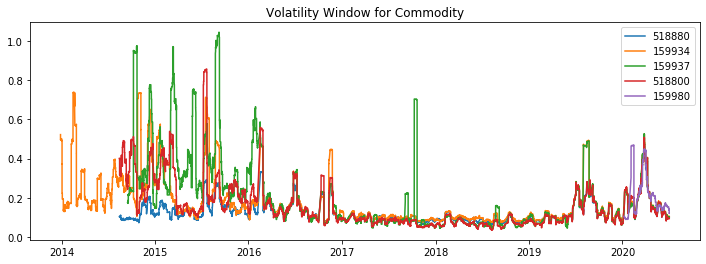

In [37]:
for k, v in c.etf_dict.items():
    fig = plt.figure(figsize=(12,4))
    for sym in v:
        plt.plot(vol_dict[sym], label = sym)
    plt.title(f"Volatility Window for {k}")
    plt.legend(loc = 'best')
    plt.savefig(f'{k}.png')
    plt.show()

In [38]:
np.save('vol_window.npy',vol_dict)
np.save('return.npy',return_dict)

In [3]:
vol_dict = np.load('vol_window.npy',allow_pickle = True).item()
vol_dict

{'510300': datetime
 2012-06-08 14:51:00    0.157506
 2012-06-08 14:52:00    0.157409
 2012-06-08 14:53:00    0.157421
 2012-06-08 14:54:00    0.157360
 2012-06-08 14:55:00    0.157398
                          ...   
 2020-07-01 14:56:00    0.124996
 2020-07-01 14:57:00    0.125001
 2020-07-01 14:58:00    0.125019
 2020-07-01 14:59:00    0.124983
 2020-07-01 15:00:00    0.124978
 Name: vol_window, Length: 470813, dtype: float64,
 '510330': datetime
 2013-01-29 14:51:00    0.219590
 2013-01-29 14:52:00    0.219580
 2013-01-29 14:53:00    0.219545
 2013-01-29 14:54:00    0.219596
 2013-01-29 14:55:00    0.219728
                          ...   
 2020-07-01 14:56:00    0.125840
 2020-07-01 14:57:00    0.125854
 2020-07-01 14:58:00    0.125769
 2020-07-01 14:59:00    0.125862
 2020-07-01 15:00:00    0.125902
 Name: vol_window, Length: 432567, dtype: float64,
 '510050': datetime
 2005-03-09 14:51:00    0.192964
 2005-03-09 14:52:00    0.187531
 2005-03-09 14:53:00    0.185422
 2005-03-09 1

In [6]:
return_dict = np.load('return.npy',allow_pickle = True).item()
return_dict

{'510300': datetime
 2012-05-28 09:31:00   -0.001177
 2012-05-28 09:32:00    0.000000
 2012-05-28 09:33:00    0.001177
 2012-05-28 09:34:00    0.000392
 2012-05-28 09:35:00   -0.000392
                          ...   
 2020-07-01 14:56:00    0.000703
 2020-07-01 14:57:00    0.000234
 2020-07-01 14:58:00    0.000702
 2020-07-01 14:59:00   -0.000468
 2020-07-01 15:00:00    0.000000
 Name: return, Length: 473212, dtype: float64,
 '510330': datetime
 2013-01-16 09:31:00   -0.000387
 2013-01-16 09:32:00   -0.000775
 2013-01-16 09:33:00    0.001162
 2013-01-16 09:34:00    0.000000
 2013-01-16 09:35:00    0.000387
                          ...   
 2020-07-01 14:56:00    0.000000
 2020-07-01 14:57:00    0.000467
 2020-07-01 14:58:00    0.000467
 2020-07-01 14:59:00   -0.000934
 2020-07-01 15:00:00    0.000700
 Name: return, Length: 434966, dtype: float64,
 '510050': datetime
 2005-02-23 09:31:00   -0.009060
 2005-02-23 09:32:00   -0.005705
 2005-02-23 09:33:00    0.000000
 2005-02-23 09:34:00 

## add sharpe ratio, sortino ratio, MAR

In [9]:
res.set_index('Symbol', inplace = True)

In [10]:
res

,Type,Daily Turover,Avg Spread,Avg Spread 10%,Avg Spread 90%,Clean Rate,Annualize Vol
Symbol,,,,,,,
510300,BigCapIndex,1.284214e+09,0.001246,0.001,0.002,0.000786,0.222618
510330,BigCapIndex,1.713188e+08,0.004249,0.001,0.009,0.000458,0.298445
510050,BigCapIndex,1.089855e+09,0.001083,0.001,0.001,0.000383,0.258059
159919,BigCapIndex,2.708101e+08,0.002079,0.001,0.004,0.001917,0.424175
510310,BigCapIndex,3.193549e+07,0.002060,0.001,0.004,0.000938,0.345603
159949,SmallCapIndex,2.941898e+08,0.001107,0.001,0.001,0.000280,0.329510
510500,SmallCapIndex,4.510816e+08,0.002769,0.001,0.005,0.001143,0.572645
159915,SmallCapIndex,5.281489e+08,0.001180,0.001,0.002,0.002998,0.320084
512500,SmallCapIndex,6.939130e+07,0.005466,0.001,0.015,0.001533,0.442775


In [34]:
#rate_free_year = 1.75/100
#rate_free_min = (1+rate_free_year)**(1/365 * 24 * 60)-1
for k,v in return_dict.items():
    nav = (1+v).cumprod()
    ret = nav.iloc[-1] - 1
    ret_year = (1 + ret) ** (252 * 4 * 60 / len(v)) - 1
    sharpe = ret_year /res.loc[int(k), 'Annual Vol']
    DD = v[ np.where(v < 0)[0]].std() * np.sqrt(252 * 4 * 60)
    sortino = ret_year / DD
    MDD = max(1 - nav / nav.cummax())
    MAR = ret_year / MDD
    res.at[int(k),'Annual Return'] = ret_year
    res.at[int(k), 'Sharpe'] = sharpe
    res.at[int(k), 'Sortino'] = sortino
    res.at[int(k), 'MAR'] = MAR
pd.set_option('max_columns',1000)
res

,Type,Daily Turover,Avg Spread,10% Spread,90% Spread,Clean Rate,Annual Vol,Annual Return,Sharpe,Sortino,MAR
Symbol,,,,,,,,,,,
510300,BigCapIndex,1.284214e+09,0.001246,0.001,0.002,0.000786,0.222618,0.041960,0.188486,0.201353,0.082817
510330,BigCapIndex,1.713188e+08,0.004249,0.001,0.009,0.000458,0.298445,0.026085,0.087403,0.068637,0.046185
510050,BigCapIndex,1.089855e+09,0.001083,0.001,0.001,0.000383,0.258059,0.050603,0.196090,0.214274,0.066909
159919,BigCapIndex,2.708101e+08,0.002079,0.001,0.004,0.001917,0.424175,0.135936,0.320473,0.509717,0.260945
510310,BigCapIndex,3.193549e+07,0.002060,0.001,0.004,0.000938,0.345603,0.029872,0.086435,0.058717,0.053607
159949,SmallCapIndex,2.941898e+08,0.001107,0.001,0.001,0.000280,0.329510,-0.068212,-0.207009,-0.253203,-0.109833
510500,SmallCapIndex,4.510816e+08,0.002769,0.001,0.005,0.001143,0.572645,0.169659,0.296273,0.506193,0.239808
159915,SmallCapIndex,5.281489e+08,0.001180,0.001,0.002,0.002998,0.320084,0.083151,0.259779,0.278746,0.109568
512500,SmallCapIndex,6.939130e+07,0.005466,0.001,0.015,0.001533,0.442775,-0.176252,-0.398061,-0.270488,-0.228746


## 增加月度sharpe, sortino, MAR

In [79]:
import datetime
ret_m_df = pd.DataFrame(columns = res.index, index = [])
sharpe_m_df = pd.DataFrame(columns = res.index, index = [])
sortino_m_df = pd.DataFrame(columns = res.index, index = [])
MAR_m_df = pd.DataFrame(columns = res.index, index = [])
for k,v in return_dict.items():
    for month, df_m in v.groupby([v.index.year, v.index.month]):
        nav_m = (1+df_m).cumprod()
        ret_m = nav_m.iloc[-1] - 1
        ret_year = (1 + ret_m) ** (252 * 4 * 60 / len(df_m)) - 1
        std_year = df_m.std() * np.sqrt(252 * 4 * 60)
        sharpe = ret_year / std_year
        DD = df_m[ np.where(df_m < 0)[0]].std() * np.sqrt(252 * 4 * 60)
        sortino = ret_year / DD
        MDD = max(1 - nav_m / nav_m.cummax())
        MAR = ret_year / MDD
        ret_m_df.at[datetime.date(month[0], month[1],1), int(k)] = ret_year
        sharpe_m_df.at[datetime.date(month[0], month[1],1), int(k)] = sharpe
        sortino_m_df.at[datetime.date(month[0], month[1],1), int(k)] = sortino
        MAR_m_df.at[datetime.date(month[0], month[1],1),int(k)] = MAR

In [82]:
ret_m_df.sort_index(inplace = True)
sharpe_m_df.sort_index(inplace = True)
sortino_m_df.sort_index(inplace = True)
MAR_m_df.sort_index(inplace = True)

In [83]:
sharpe_m_df

Symbol,510300,510330,510050,159919,510310,159949,510500,159915,512500,159968,515800,512990,512380,512160,512090,159995,512760,515050,159801,512480,512290,159992,512170,512010,159938,515000,515750,159807,515860,159987,515030,515700,159806,512880,512000,512800,512900,159993,159928,512690,515650,159996,510150,512660,512710,515210,512400,515220,159966,159905,159967,510880,515180,515680,515900,159976,515600,159978,511010,511260,159972,510900,159920,513050,513090,513500,518880,159934,159937,518800,159980
2005-02-01,NaN,NaN,-3.05817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-01,NaN,NaN,-3.51262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-01,NaN,NaN,-0.488345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-05-01,NaN,NaN,-2.91935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-01,NaN,NaN,1.9943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-01,NaN,NaN,2.26082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-08-01,NaN,NaN,2.94576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-09-01,NaN,NaN,-1.87978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-10-01,NaN,NaN,-2.70231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-11-01,NaN,NaN,0.209205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
ret_m_df.to_csv('月度收益表.csv')
sharpe_m_df.to_csv('月度夏普比率.csv')
sortino_m_df.to_csv('月度索提诺比率.csv')
MAR_m_df.to_csv('月度MAR比例.csv')
res.to_csv("ETF归总表.csv")

In [78]:
res = pd.read_csv("ETF归总表.csv", index_col = 0)
pd.set_option('max_columns',1000)
pd.set_option('max_row', 300)
res

datetime.date(12, 4, 1)

In [86]:
writer = pd.ExcelWriter("ETF数据表.xlsx")
res.to_excel(writer, sheet_name = "全周期数据")
ret_m_df.to_excel(writer, sheet_name = '年化月度收益率')
sharpe_m_df.to_excel(writer, sheet_name = '月度夏普比率')
sortino_m_df.to_excel(writer, sheet_name = '月度索提诺比率')
MAR_m_df.to_excel(writer, sheet_name = '月度MAR比率')
writer.save()

,Type,Daily Turover,Avg Spread,10% Spread,90% Spread,Clean Rate,Annual Vol,Annual Return,Sharpe,Sortino,MAR
Symbol,,,,,,,,,,,
510300,BigCapIndex,1.284214e+09,0.001246,0.001,0.002,0.000786,0.222618,0.041960,0.188486,0.201353,0.082817
510330,BigCapIndex,1.713188e+08,0.004249,0.001,0.009,0.000458,0.298445,0.026085,0.087403,0.068637,0.046185
510050,BigCapIndex,1.089855e+09,0.001083,0.001,0.001,0.000383,0.258059,0.050603,0.196090,0.214274,0.066909
159919,BigCapIndex,2.708101e+08,0.002079,0.001,0.004,0.001917,0.424175,0.135936,0.320473,0.509717,0.260945
510310,BigCapIndex,3.193549e+07,0.002060,0.001,0.004,0.000938,0.345603,0.029872,0.086435,0.058717,0.053607
159949,SmallCapIndex,2.941898e+08,0.001107,0.001,0.001,0.000280,0.329510,-0.068212,-0.207009,-0.253203,-0.109833
510500,SmallCapIndex,4.510816e+08,0.002769,0.001,0.005,0.001143,0.572645,0.169659,0.296273,0.506193,0.239808
159915,SmallCapIndex,5.281489e+08,0.001180,0.001,0.002,0.002998,0.320084,0.083151,0.259779,0.278746,0.109568
512500,SmallCapIndex,6.939130e+07,0.005466,0.001,0.015,0.001533,0.442775,-0.176252,-0.398061,-0.270488,-0.228746


# 比较沪深300（399300） 和华夏柏瑞沪深300ETF （510300）

In [41]:
c = ETFClassification()
vol_399300 = c.etf_vol('399300')
res = combine_time(vol_399300[1])
vol_dict['399300'] = res['vol_window'].dropna()
return_dict['399300'] = res['return']

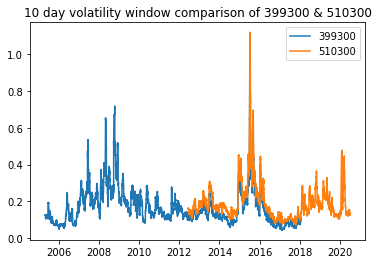

In [42]:
plt.plot(vol_dict['399300'], label = '399300')
plt.plot(vol_dict['510300'],label = '510300')
plt.legend(loc = 'best')
plt.title('10 day volatility window comparison of 399300 & 510300')
plt.savefig('399300vs510300.png')
plt.show()

# 比较上证50 （000016）和华夏上证50ETF （510050）

In [43]:
vol_000016 = c.etf_vol('000016')
res = combine_time(vol_000016[1])
vol_dict['000016'] = res['vol_window'].dropna()
return_dict['000016'] = res['return']

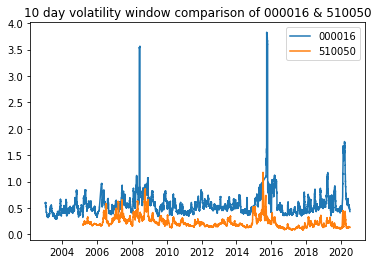

In [44]:
plt.plot(vol_dict['000016'], label = '000016')
plt.plot(vol_dict['510050'],label = '510050')
plt.legend(loc = 'best')
plt.title('10 day volatility window comparison of 000016 & 510050')
plt.savefig('000016vs510050.png')
plt.show()

#  比较中证500指数（000905）和南方中证500ETF （510500）

In [45]:
vol_000905 = c.etf_vol('000905')
res = combine_time(vol_000905[1])
vol_dict['000905'] = res['vol_window'].dropna()
return_dict['000905'] = res['return']

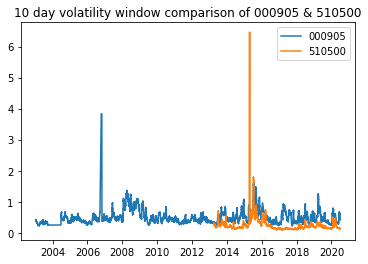

In [46]:
plt.plot(vol_dict['000905'], label = '000905')
plt.plot(vol_dict['510500'],label = '510500')
plt.legend(loc = 'best')
plt.title('10 day volatility window comparison of 000905 & 510500')
plt.savefig('000905vs510500.png')
plt.show()

# Correlation between ETFs

In [6]:
corr_rolling_dict = {}
return_pair_dict = {}
for k,v in c.etf_dict.items():
    temp_dict = {}
    for i in range(len(v)):
        for j in range(i+1,len(v)):
            temp_df = pd.DataFrame(return_dict[v[i]]).join(pd.DataFrame(return_dict[v[j]]),how = 'inner', lsuffix = v[i], rsuffix = v[j])
            temp_dict[f"{v[i]}vs{v[j]}"] = temp_df [f"return{v[i]}"].rolling(90 * 4 * 60).corr(temp_df[f"return{v[j]}"]).dropna()
            return_pair_dict[f"{v[i]}vs{v[j]}"] = temp_df
    corr_rolling_dict[k] = temp_dict

In [ ]:
corr_rolling_dict

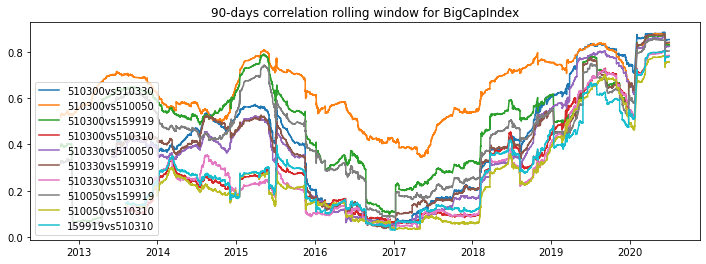

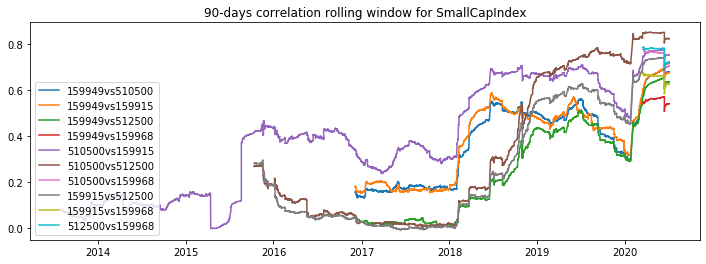

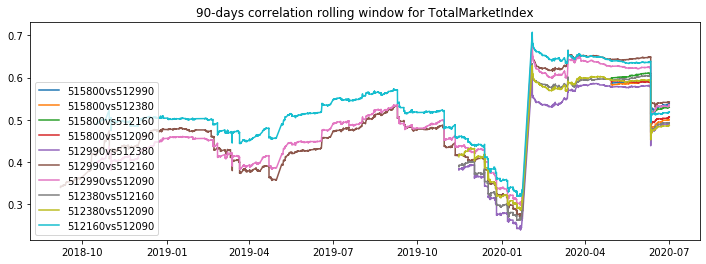

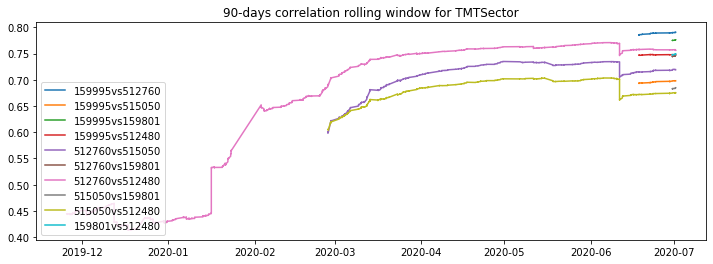

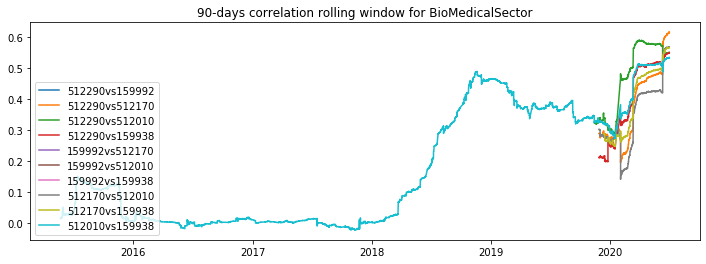

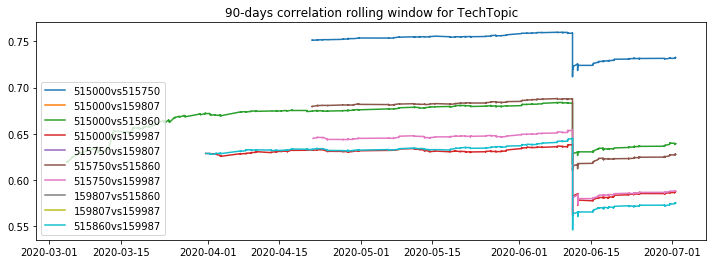

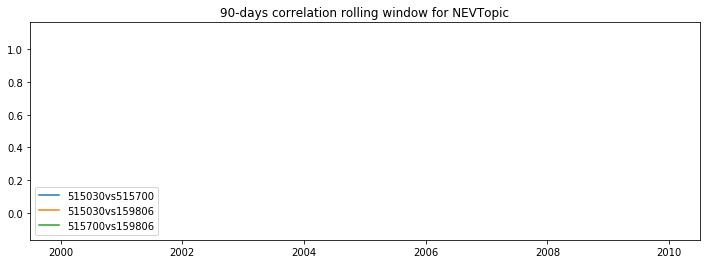

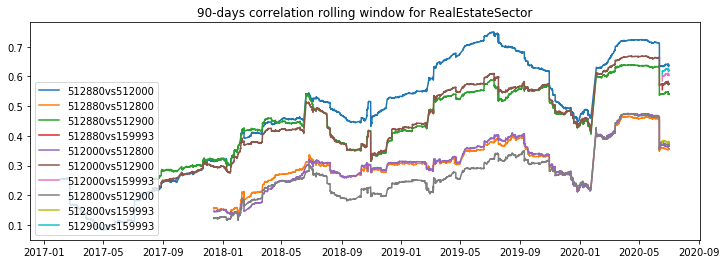

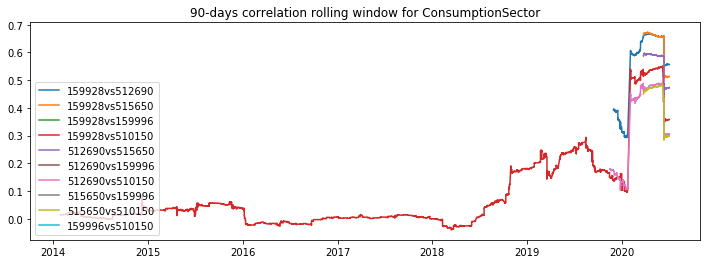

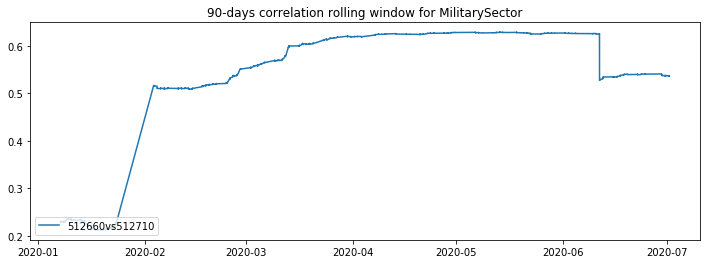

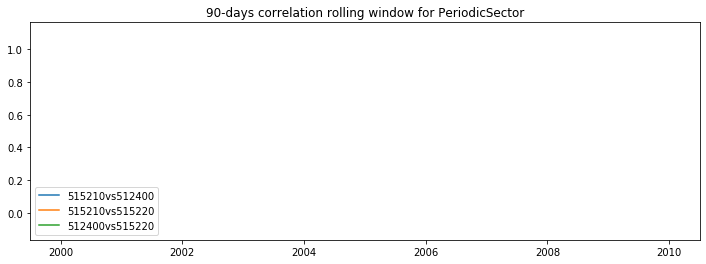

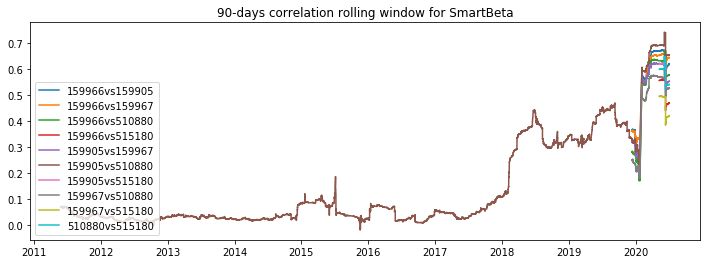

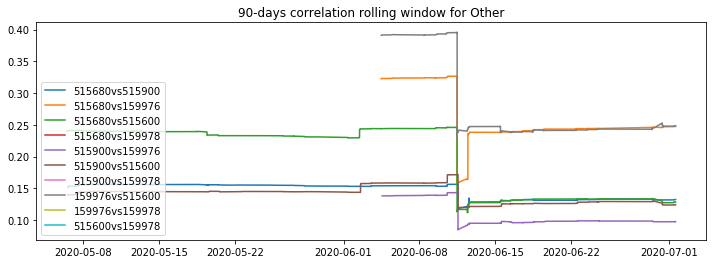

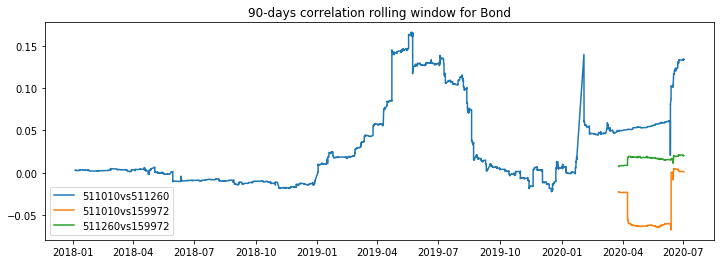

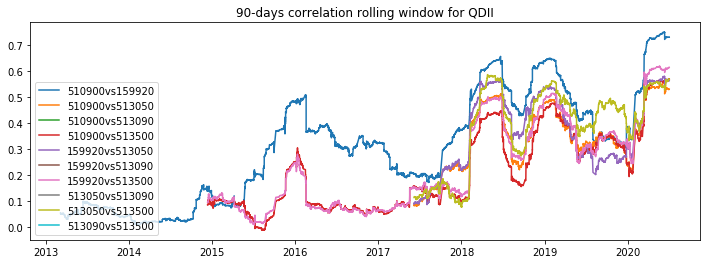

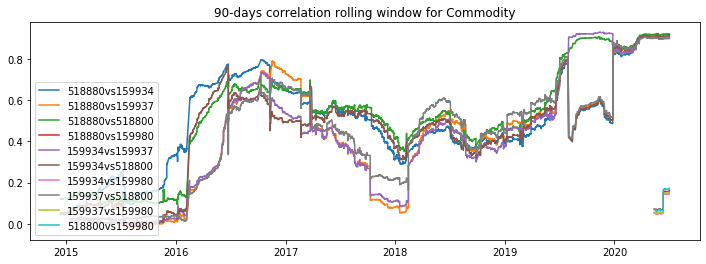

In [7]:
for k,v in corr_rolling_dict.items():
    plt.figure(figsize=(12,4))
    for title, df in v.items():
        plt.plot(df, label = title)
    plt.title(f'90-days correlation rolling window for {k}')
    plt.legend(loc = 'lower left')
    plt.savefig(f"corr_window_{k}.png")
    plt.show()

In [41]:
corr_rolling_dict['TotalMarketIndex']['512160vs512090'].iloc[74825:74850]

datetime
2020-01-23 14:54:00    0.329061
2020-01-23 14:55:00    0.329045
2020-01-23 14:56:00    0.329028
2020-01-23 14:57:00    0.329028
2020-01-23 14:58:00    0.329011
2020-01-23 14:59:00    0.329010
2020-01-23 15:00:00    0.329010
2020-02-03 09:31:00    0.706947
2020-02-03 09:32:00    0.706872
2020-02-03 09:33:00    0.706706
2020-02-03 09:34:00    0.706706
2020-02-03 09:35:00    0.706609
2020-02-03 09:36:00    0.706560
2020-02-03 09:37:00    0.705939
2020-02-03 09:38:00    0.703264
2020-02-03 09:39:00    0.703247
2020-02-03 09:40:00    0.700148
2020-02-03 09:41:00    0.700054
2020-02-03 09:42:00    0.699237
2020-02-03 09:43:00    0.699430
2020-02-03 09:44:00    0.698828
2020-02-03 09:45:00    0.698849
2020-02-03 09:46:00    0.695725
2020-02-03 09:47:00    0.694727
2020-02-03 09:48:00    0.693824
dtype: float64

In [55]:
corr_rolling_dict['TotalMarketIndex']['512160vs512090'].iloc[96200:96500]

datetime
2020-06-10 10:44:00    0.635622
2020-06-10 10:45:00    0.635622
2020-06-10 10:46:00    0.635689
2020-06-10 10:47:00    0.635748
2020-06-10 10:48:00    0.635891
2020-06-10 10:49:00    0.635917
2020-06-10 10:50:00    0.635917
2020-06-10 10:51:00    0.635917
2020-06-10 10:52:00    0.635910
2020-06-10 10:53:00    0.635910
2020-06-10 10:54:00    0.636073
2020-06-10 10:55:00    0.636067
2020-06-10 10:56:00    0.636067
2020-06-10 10:57:00    0.636067
2020-06-10 10:58:00    0.636067
2020-06-10 10:59:00    0.636126
2020-06-10 11:00:00    0.636126
2020-06-10 11:01:00    0.636118
2020-06-10 11:02:00    0.636125
2020-06-10 11:03:00    0.636125
2020-06-10 11:04:00    0.636126
2020-06-10 11:05:00    0.636118
2020-06-10 11:06:00    0.636118
2020-06-10 11:07:00    0.636118
2020-06-10 11:08:00    0.636126
2020-06-10 11:09:00    0.636080
2020-06-10 11:10:00    0.636080
2020-06-10 11:11:00    0.636095
2020-06-10 11:12:00    0.636095
2020-06-10 11:13:00    0.636095
2020-06-10 11:14:00    0.636095

# 各类流动性最好的ETF相关性分析

In [14]:
list_liq= ['510050', '159995', '512090', '515050', '512290', '515000', '515700', '512800', 
           '159928', '512660', '512400', '510880', '159976', '511010', '510900', '518880']
assert len(list_liq) == 16

In [15]:
corr_sector_dict = {}

for i in range(len(list_liq)):
    for j in range(i+1,len(list_liq)):
        temp_df = pd.DataFrame(return_dict[list_liq[i]]).join(pd.DataFrame(return_dict[list_liq[j]]),
                                                       how = 'inner', lsuffix = list_liq[i], 
                                                       rsuffix = list_liq[j])
        corr_sector_dict[f"{list_liq[i]}vs{list_liq[j]}"] = temp_df [f"return{list_liq[i]}"].rolling(
            90 * 4 * 60).corr(temp_df[f"return{list_liq[j]}"]).dropna()
        return_pair_dict[f"{list_liq[i]}vs{list_liq[j]}"] = temp_df

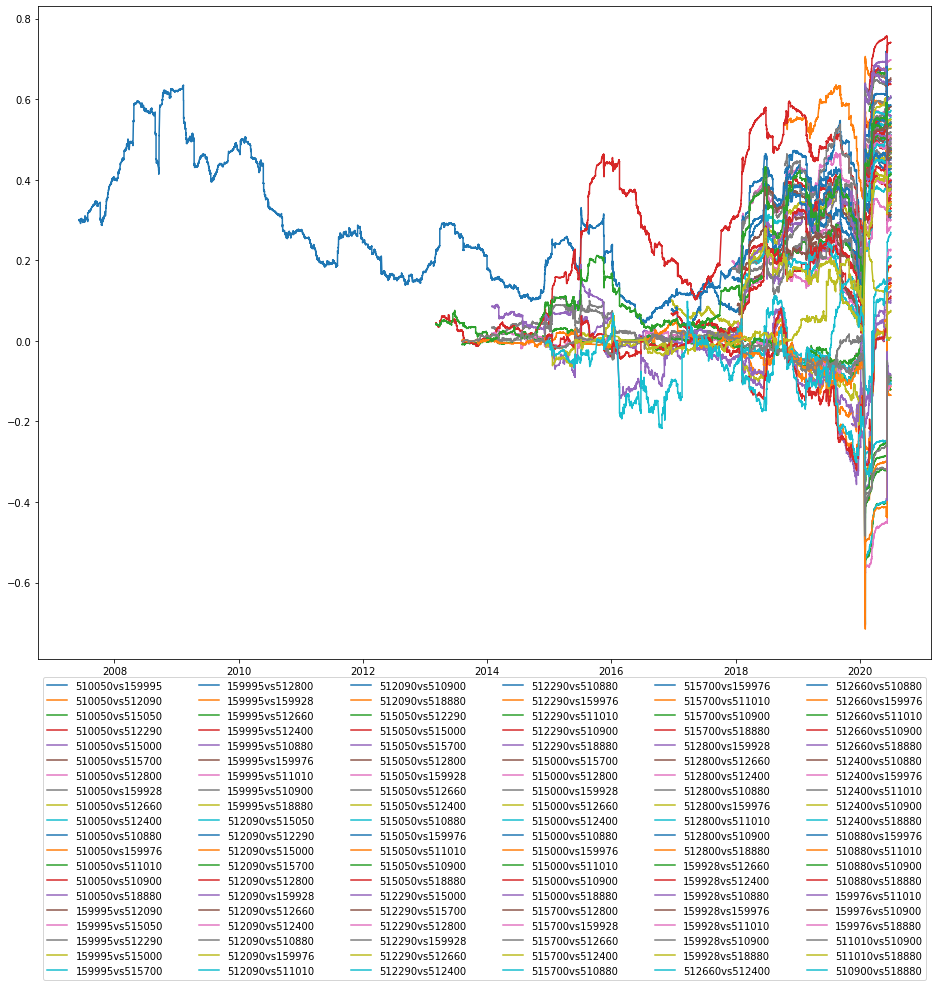

In [16]:
plt.figure(figsize=(16,12))
for k,v in corr_sector_dict.items():
    plt.plot(v, label = k)
plt.legend(bbox_to_anchor=(0., -0.01, 1.,-0.01), loc='upper left', ncol = 6, mode="expand")
plt.savefig(f"corr_window_sector.png")
plt.show()

In [17]:
np.save('corr_rolling.npy',corr_rolling_dict)
np.save('corr_sector.npy',corr_sector_dict)
np.save('return_pair.npy',return_pair_dict)

In [3]:
corr_rolling_dict = np.load('corr_rolling.npy',allow_pickle = True).item()
corr_rolling_dict

{'BigCapIndex': {'510300vs510330': datetime
  2013-06-04 13:31:00    0.378950
  2013-06-04 13:32:00    0.379098
  2013-06-04 13:33:00    0.379105
  2013-06-04 13:34:00    0.379075
  2013-06-04 13:35:00    0.379087
                           ...   
  2020-07-01 14:56:00    0.853115
  2020-07-01 14:57:00    0.853120
  2020-07-01 14:58:00    0.853125
  2020-07-01 14:59:00    0.853130
  2020-07-01 15:00:00    0.853124
  Length: 413845, dtype: float64,
  '510300vs510050': datetime
  2012-10-08 13:31:00    0.518305
  2012-10-08 13:32:00    0.518349
  2012-10-08 13:33:00    0.518385
  2012-10-08 13:34:00    0.518386
  2012-10-08 13:35:00    0.518323
                           ...   
  2020-07-01 14:56:00    0.838631
  2020-07-01 14:57:00    0.838626
  2020-07-01 14:58:00    0.838628
  2020-07-01 14:59:00    0.838642
  2020-07-01 15:00:00    0.838647
  Length: 452093, dtype: float64,
  '510300vs159919': datetime
  2012-10-08 13:31:00    0.391017
  2012-10-08 13:32:00    0.392147
  2012-10-08 1

In [4]:
corr_sector_dict = np.load('corr_sector.npy',allow_pickle = True).item()
corr_sector_dict

{'510050vs159995': datetime
 2020-06-18 10:33:00    0.535311
 2020-06-18 10:34:00    0.535494
 2020-06-18 10:35:00    0.535494
 2020-06-18 10:36:00    0.535467
 2020-06-18 10:37:00    0.535478
                          ...   
 2020-07-01 14:56:00    0.539820
 2020-07-01 14:57:00    0.539820
 2020-07-01 14:58:00    0.539849
 2020-07-01 14:59:00    0.539845
 2020-07-01 15:00:00    0.539847
 Length: 1874, dtype: float64,
 '510050vs512090': datetime
 2018-10-17 09:42:00    0.535423
 2018-10-17 09:43:00    0.535486
 2018-10-17 09:44:00    0.535526
 2018-10-17 09:45:00    0.535449
 2018-10-17 09:46:00    0.535486
                          ...   
 2020-07-01 14:56:00    0.533477
 2020-07-01 14:57:00    0.533484
 2020-07-01 14:58:00    0.533486
 2020-07-01 14:59:00    0.533480
 2020-07-01 15:00:00    0.533489
 Length: 99570, dtype: float64,
 '510050vs515050': datetime
 2020-02-27 10:33:00    0.570721
 2020-02-27 10:34:00    0.570788
 2020-02-27 10:35:00    0.570772
 2020-02-27 10:36:00    0.57

In [6]:
return_pair_dict = np.load('return_pair.npy',allow_pickle = True).item()
return_pair_dict

{'510300vs510330':                      return510300  return510330
 datetime                                       
 2013-01-16 09:31:00     -0.000386     -0.000387
 2013-01-16 09:32:00      0.000772     -0.000775
 2013-01-16 09:33:00      0.000386      0.001162
 2013-01-16 09:34:00     -0.000386      0.000000
 2013-01-16 09:35:00      0.000771      0.000387
 ...                           ...           ...
 2020-07-01 14:56:00      0.000703      0.000000
 2020-07-01 14:57:00      0.000234      0.000467
 2020-07-01 14:58:00      0.000702      0.000467
 2020-07-01 14:59:00     -0.000468     -0.000934
 2020-07-01 15:00:00      0.000000      0.000700
 
 [435444 rows x 2 columns],
 '510300vs510050':                      return510300  return510050
 datetime                                       
 2012-05-28 09:31:00     -0.001177      0.000000
 2012-05-28 09:32:00      0.000000      0.000565
 2012-05-28 09:33:00      0.001177      0.000000
 2012-05-28 09:34:00      0.000392      0.001129
 20

## select most correlated pairs

In [6]:
corr_sector_df = pd.DataFrame(index = corr_sector_dict.keys(), columns = ['mean', '25%', '75%'])
for k,v in corr_sector_dict.items():
    corr_sector_df.loc[k,:] = [v.mean(), v.quantile(0.25), v.quantile(0.75)]
pd.set_option('max_columns',1000)
pd.set_option('max_row', 300)
corr_sector_df

,mean,25%,75%
510050vs159995,0.537895,0.536506,0.539416
510050vs512090,0.575753,0.540009,0.630363
510050vs515050,0.640967,0.604646,0.664919
510050vs512290,0.398413,0.319182,0.478767
510050vs515000,0.655389,0.608852,0.692148
510050vs515700,0.578868,0.576828,0.580552
510050vs512800,0.396318,0.346125,0.440667
510050vs159928,0.137772,0.0184112,0.225807
510050vs512660,0.239744,0.0736295,0.334763
510050vs512400,0.227367,0.166663,0.235309


In [22]:
idx = np.where(corr_sector_df['75%'] < -0.1)[0]
idx

array([51, 72, 81], dtype=int64)

In [23]:
idx2 = np.where(corr_sector_df['25%'] > 0.55)[0]
idx2

array([ 2,  4,  5, 16, 18, 43, 44, 65, 79], dtype=int64)

In [24]:
idx = sorted(np.concatenate((idx, idx2)))
corr_sector_df.iloc[idx]

,mean,25%,75%
510050vs515050,0.640967,0.604646,0.664919
510050vs515000,0.655389,0.608852,0.692148
510050vs515700,0.578868,0.576828,0.580552
159995vs515050,0.695865,0.694592,0.697377
159995vs515000,0.674703,0.67415,0.675323
515050vs515000,0.728602,0.723954,0.747377
515050vs515700,0.602981,0.602,0.603471
515050vs511010,-0.288374,-0.319396,-0.30083
515000vs515700,0.64835,0.647229,0.649192
515000vs511010,-0.287613,-0.336231,-0.28719


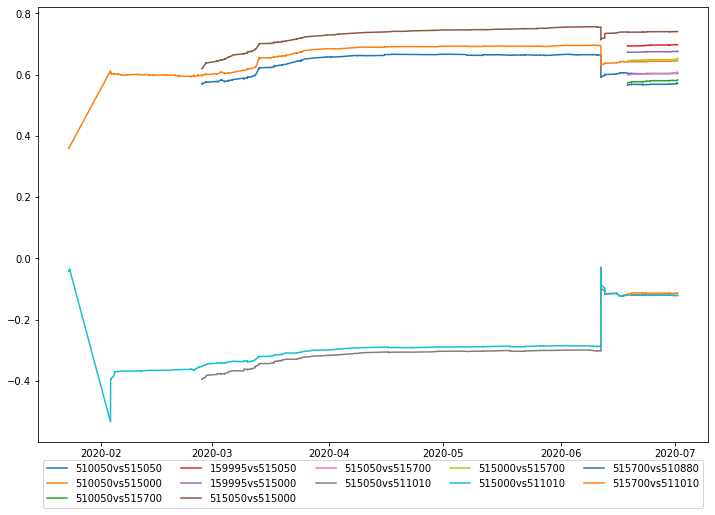

In [25]:
plt.figure(figsize=(12,8))
for i in corr_sector_df.iloc[idx].index:
    plt.plot(corr_sector_dict[i], label = i)
plt.legend(bbox_to_anchor=(0., -0.015, 1.,-0.015), loc='upper left', ncol = 5, mode="expand")
plt.savefig(f"corr_window_sector_selected.png")
plt.show()

## 上面的效果不是很好，换一种方式select

In [ ]:
ini = False
for k,v in corr_sector_dict.items():
    if not ini:
        corr_sector_df2 = pd.DataFrame(v, columns = [k])
        ini = True
    else:
        corr_sector_df2 = pd.DataFrame(v, columns = [k]).join(corr_sector_df2, how = 'outer')

,510050vs515050,159995vs515050
datetime,,
2020-02-27 10:33:00,0.570721,NaN
2020-02-27 10:34:00,0.570788,NaN
2020-02-27 10:35:00,0.570772,NaN
2020-02-27 10:36:00,0.570789,NaN
2020-02-27 10:37:00,0.570816,NaN
...,...,...
2020-07-01 14:56:00,0.604491,0.698104
2020-07-01 14:57:00,0.604502,0.698107
2020-07-01 14:58:00,0.604518,0.698089


,510050vs515050
datetime,
2020-02-27 10:33:00,0.570721
2020-02-27 10:34:00,0.570788
2020-02-27 10:35:00,0.570772
2020-02-27 10:36:00,0.570789
2020-02-27 10:37:00,0.570816
...,...
2020-07-01 14:56:00,0.604491
2020-07-01 14:57:00,0.604502
2020-07-01 14:58:00,0.604518
